In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler

In [10]:
dataset = pd.read_csv('/content/time_series.csv')

In [11]:
dataset.head()

,date,date_float,value
0,02-01-2020,2020.002740,1.000000
1,03-01-2020,2020.005479,0.994549
2,06-01-2020,2020.013699,0.999416
3,07-01-2020,2020.016438,1.004152
4,08-01-2020,2020.019178,1.002922


In [12]:
df=dataset.drop(['date','date_float'],axis=1)

Train Length: 250
Test Length: 77
Number of Timesteps: 60
1/1 [==============================] - 0s 34ms/step


<ipython-input-25-7aba24dfc1f5>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['Predictions'] = true_predictions


<Axes: >

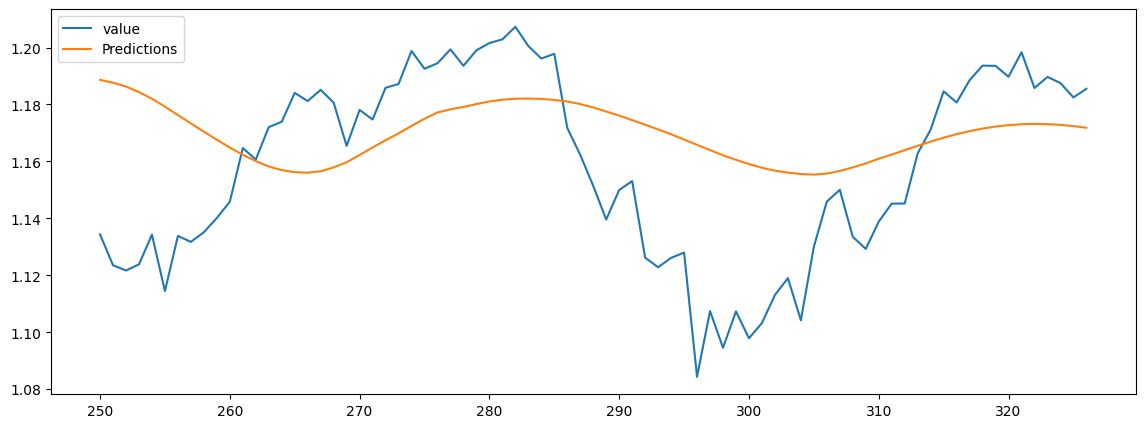

In [25]:
def lstm(ltrain, ltest,ts):
  train_set= df.iloc[:ltrain]
  test_set=df.iloc[-ltest:]
  scaler = MinMaxScaler(feature_range=(0, 1))
  scale_train_set = scaler.fit_transform(train_set)
  X_train = []
  Y_train = []
  for i in range(ts, ltrain):
      X_train.append(scale_train_set[i - ts:i, 0])
      Y_train.append(scale_train_set[i, 0])
  X_train = np.array(X_train)
  Y_train = np.array(Y_train)
  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

  regressor = Sequential()
  regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
  regressor.add(Dropout(0.2))
  regressor.add(LSTM(units=50, return_sequences=True))
  regressor.add(Dropout(0.2))
  regressor.add(LSTM(units=50, return_sequences=True))
  regressor.add(Dropout(0.2))
  regressor.add(LSTM(units=50))
  regressor.add(Dropout(0.2))
  regressor.add(Dense(units=1))
  regressor.compile(optimizer='adam', loss='mean_squared_error')
  regressor.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=0)

  scale_test_set = scaler.fit_transform(test_set)
  n_input=ts
  n_features=1
  test_predictions = []
  first_eval_batch = scale_train_set[-n_input:]
  current_batch = first_eval_batch.reshape((1, n_input, n_features))

  for i in range(len(test_set)):
    current_pred = regressor.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],
                            [[current_pred]],
                            axis=1)
  true_predictions = scaler.inverse_transform(test_predictions)

  test_set['Predictions'] = true_predictions
  return test_set.plot(figsize=(14,5))

len_train= int(input("Train Length: "))
len_test= int(input("Test Length: "))
timesteps=int(input("Number of Timesteps: "))

lstm(len_train,len_test,timesteps)